# Validation of the different aspects of the model </a><a name='top'>

A few physical outputs from the model are evaluated here, and compared to observational data. These include SWE and height values above clearly identified snowpack layers, density profile, temperature profile, and total height of the snowpack.

Parameters are defined in the file **parameter.py**, to be adjusted before launching the notebook, but additional information must be filled in in [**this section**](#fill-in). Once these two sections are filled-in, the whole notebook may be run.

In [1]:
# TODO run for several points and store end data for stats?
# TODO interpolate temperature values?

## 0. Simulated snowpack creation

### Define parameters </a><a name='fill-in'>

In [2]:
dataset_file_name = 'snow_pit_1_filled.nc'

In [3]:
# Observations
# TODO make a netcdf file from the pits? > use functions as for simulations?

sampling_length = 0.1   # depth between two samples of the snowpack, in meters
ref_layer_indices = [1, 2]   # indices of the layers directly below ice interfaces

# Density
observed_ro_profile = [350, 350, 280, 240, 250, 220, 260]    # Careful to put the data in the correct order, from bottom to top

# SWE
observed_swe = [10, 25]   # corresponding SWE above these layers
observed_ave_density = [269, 350]

# Heights
observed_heights = [70, 120]   # corresponding height above these layers
observed_total_height = 150

# Temperature
observed_temp_profile = [-4, -5, -5, -6, -6, -9, -11]     # Careful to put the data in the correct order, from bottom to top

[Back to top section](#top)

### Simulation

In [4]:
# Imports

%run little_awk_functions.py
%run parameters.py

In get_met_forcing() - Warning: check the format of your file corresponds to the indices given in the functions (wind speed 5, surface temperature 8, time 0).


In [5]:
# Clean dataset

data_set_used = xr.open_dataset(dataset_file_name)

data_set_used = data_set_used.ffill(dim='time')

median_space_filtering(data_set_used, 5, x_span=9, y_span=9)
median_time_filtering(data_set_used, 11)

data_set_used['snow_surface'] = data_set_used['snow_surface'] - data_set_used['snow_surface'].isel(x=x_sel, y=y_sel).dropna('time').min()

---> Median filtering in space with a window [9, 9]
---> Median filtering in time with a window of 11


In [6]:
# Define dates

data_starting_date_in_ns = float(data_set_used.time.values[0])

data_starting_date_in_s = pd.to_datetime(data_set_used.time.values[0]).timestamp()
data_ending_date_in_s = pd.to_datetime(data_set_used.time.values[-1]).timestamp()
data_duration_in_s = data_ending_date_in_s - data_starting_date_in_s
nb_iterations = int(data_duration_in_s/dt + 1)

In [7]:
# Get timing of snow events

results = get_snow_events(data_set_used, x_sel, y_sel, time_window_std, std_threshold)
start_accumulation, start_erosion, end_accumulation, end_erosion = results[0], results[1], results[2], results[3]

# Convert end times into more manageable orders of magnitude (seconds)

end_accumulation_times = data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time=end_accumulation)
end_accumulation_times = (pd.to_datetime(end_accumulation_times.time).astype(int) - data_starting_date_in_ns) / 1000000000  # in s

end_erosion_times = data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time=end_erosion)
end_erosion_times = (pd.to_datetime(end_erosion_times.time).astype(int) - data_starting_date_in_ns) / 1000000000  # in s


In [8]:
# Simulate the snowpack

snowpack = simulate_snowpack_evolution(data_set_used, x_sel, y_sel, nb_iterations, end_accumulation_times, end_erosion_times,
                                       start_accumulation, end_accumulation, start_erosion, end_erosion, jj, dt, ro_layer, ro_water, ro_ice,
                                       t_old, tf, tsfc, dy_snow, age_layers, gamma, cp_snow, melt_flag, a1, a2, met_temp_data=met_temp, met_wind_data=met_wind,
                                       met_time_data=met_time, fit_top_of_snowfall_to_curve=simul_fit_top_of_snowfall_to_curve, erode_several_layers=simul_erode_several_layers)

ro_layer_evolution, depth_evolution, temperature_evolution = snowpack[0], snowpack[1], snowpack[2]


## 1. Events detection validation

This will be done by eye simply, most probably. Suggestions of what could be used for quantitative evaluation: number of events that match manually identified events (possibly divided by the total number of detected events), or use the measures used for the sensitivity tests.

## 2. Density and SWE validation

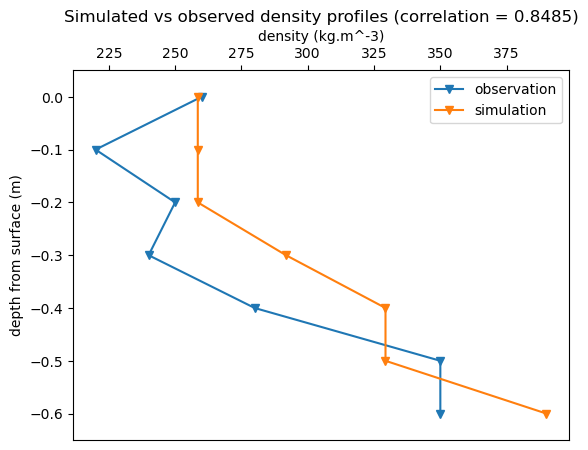

In [9]:
# Plot observed vs simulated density profiles

# Get profiles and correlation

bottom_depth = round( (len(observed_ro_profile)-1) * sampling_length, 1 )
simulated_ro_profile = density_profile(bottom_depth, sampling_length, depth_evolution[-1], ro_layer_evolution[-1])

correlation_ro = p_correl_measure(simulated_ro_profile, observed_ro_profile)

# Create figure

fig = plt.figure()
ax = fig.add_subplot()

depths_array = np.linspace(0, -bottom_depth, len(observed_ro_profile))
ax.plot(list(reversed(observed_ro_profile)), depths_array, marker='v', label='observation')
ax.plot(list(reversed(simulated_ro_profile)), depths_array, marker='v', label='simulation')

ax.set_xlabel('density (kg.m^-3)')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

ax.set_ylim(-bottom_depth-sampling_length/2, sampling_length/2)
ax.set_ylabel('depth from surface (m)')

plt.title('Simulated vs observed density profiles (correlation = ' + str(round(correlation_ro, 4)) + ')')
plt.legend()
plt.show()

In [10]:
# Get SWE comparable values

simulated_swe = [get_data_from_ref(i, ro_layer_evolution[-1], depth_evolution[-1])[0] for i in ref_layer_indices]
simulated_ave_density = [get_data_from_ref(i, ro_layer_evolution[-1], depth_evolution[-1])[2] for i in ref_layer_indices]

## 3. Height of layers validation

In [11]:
# Get height comparable values

simulated_heights = [get_data_from_ref(i, ro_layer_evolution[-1], depth_evolution[-1])[1] for i in ref_layer_indices]
simulated_total_height = sum(depth_evolution[-1][i] for i in range(len(depth_evolution[-1])))

## 4. Temperature profile validation

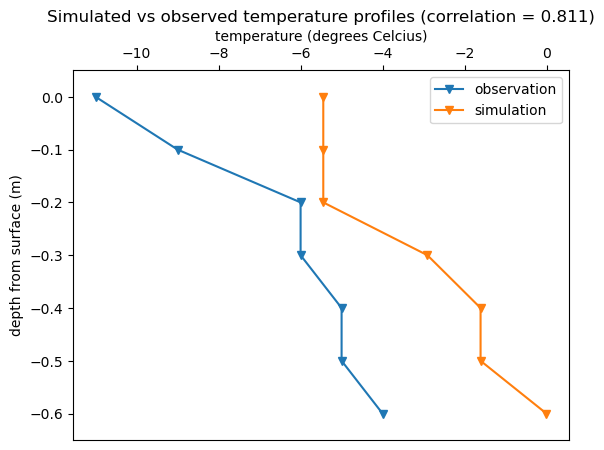

In [12]:
# Plot observed vs simulated temperature profiles

# Get profiles and correlation

bottom_depth = round( (len(observed_temp_profile)-1) * sampling_length, 1 )
simulated_temp_profile = temp_profile(bottom_depth, sampling_length, depth_evolution[-1], temperature_evolution[-1])

correlation_temp = p_correl_measure(simulated_temp_profile, observed_temp_profile)

# Create figure

fig = plt.figure()
ax = fig.add_subplot()

depths_array = np.linspace(0, -bottom_depth, len(observed_temp_profile))
ax.plot(list(reversed(observed_temp_profile)), depths_array, marker='v', label='observation')
ax.plot(list(reversed(simulated_temp_profile)), depths_array, marker='v', label='simulation')

ax.set_xlabel('temperature (degrees Celcius)')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

ax.set_ylim(-bottom_depth-sampling_length/2, sampling_length/2)
ax.set_ylabel('depth from surface (m)')

plt.title('Simulated vs observed temperature profiles (correlation = ' + str(round(correlation_temp, 4)) + ')')
plt.legend()
plt.show()